# Import

### Basic

In [1]:
import keras

Using Theano backend.
Using gpu device 0: GeForce GTX 850M (CNMeM is disabled, cuDNN 5005)


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import time

In [3]:
%matplotlib inline

In [4]:
import params

# Load dataset

In [44]:
DATASET = np.load("data/dataset.npy")

In [45]:
print "Shape :", DATASET.shape

Shape : (15075059L, 161L, 1L)


### Splitting into a trainset, a validset and a testset

In [47]:
def split_dataset(dataset, split_rate=[0.94, 0.01, 0.04], seed=123): # see preprocessing.py
    # index = 1,2,3,...,N
    N = dataset.shape[0]
    index = range(dataset.shape[0])
    # shuffle
    np.random.seed(seed)
    np.random.shuffle(index)
    # division
    train_rate, valid_rate, test_rate = np.cumsum(split_rate)
    index_train = index[0:int(train_rate*N)]
    index_valid = index[int(train_rate*N):int(valid_rate*N)]
    index_test = index[int(valid_rate*N):int(test_rate*N)]
    # return 
    return index_train, index_valid, index_test

In [48]:
index_train, index_valid, index_test = split_dataset(DATASET)

**index_train, index_valid, index_test** are such that :

trainset = DATASET[index_train]

validset = DATASET[index_valid]

testset = DATASET[index_test]

# Preprocessing function

In [5]:
ACCEPTED_CHARS = params.ACCEPTED_CHARS

In [6]:
print ACCEPTED_CHARS

['\n', ' ', '!', '"', '#', '&', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '@', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\x80', '\x92', '\x98', '\x9f', '\xa6', '\xe2', '\xf0']


In [7]:
def batch2onehot(batch, D): # see preprocessing.py
    ''' Function used during the training to encode batches.
    Input size : (batch_size, tweet_length, 1).
    Output size : (batch_size, tweet_length, D)'''
    B, T = batch.shape[0:2]
    one_hot_batch = np.zeros((B*T, D))
    one_hot_batch[range(B*T), batch.flatten()] = 1
    one_hot_batch = one_hot_batch.reshape((B,T,D))
    return one_hot_batch

def batch2tweet(batch, accepted_caracters, special_char=""): # see preprocessing.py
    '''Not optimized. But not used during the training : no need to be fast.'''
    tweets = []
    for t in batch:
        tweet = ""
        for char in t:
            try:
                tweet += accepted_caracters[char[0]]
            except:
                tweet += special_char # Special marker indicating the end of the tweet
        tweets.append(tweet)
    return tweets

def onehot2tweet(batch, accepted_caracters, special_char=""): # see preprocessing.py
    '''Not optimized. But not used during the training : no need to be fast.'''
    tweets = []
    for t in batch:
        tweet = ""
        for char in t:
            try:
                tweet += accepted_caracters[np.where(char==1)[0][0]]
            except:
                tweet += special_char # Special marker indicating the end of the tweet
        tweets.append(tweet)
    return tweets

### Test preprocessing functions

In [8]:
D = params.D  # dimension of one-hot vectors
B = params.B  # batch size for the demo
T = params.T  # max length of a tweet
batch = DATASET[0:B] 
# Dataset > One-hot
one_hot_batch = batch2onehot(batch, D)

# Pick a tweet
t = np.random.randint(B)
# Pick a char
c = np.random.randint(T)
print "Char %d from tweet %d :"%(c,t), one_hot_batch[t][c]

NameError: name 'DATASET' is not defined

#### If you want to, possible to go back in the "string" domain

In [54]:
# Using 'batch2tweet' :
t = np.random.randint(B) # Pick a tweet
print batch2tweet(batch, ACCEPTED_CHARS)[t]
# or 'onehot2tweet' if the tweet has already been converted to onehot :
print onehot2tweet(one_hot_batch, ACCEPTED_CHARS)[t]

rt @c_throwed: obama the goat for this 💀

 https://t.co/gaznhjw7ry
rt @c_throwed: obama the goat for this 💀

 https://t.co/gaznhjw7ry


# Generator

In [55]:
def batch_generator(data, index, batch_size, D): # see preprocessing.py
    # Init iterator and shuffling the dataset
    count = 0
    np.random.shuffle(index)
    while 1:
        if count+batch_size >= len(index):
            # Reset counter and shuffling
            count = 0
            np.random.shuffle(index)
        # Get raw data
        raw_batch = np.copy(data[index[count:(count+batch_size)]])
        # One-hot encoding
        one_hot_batch = batch2onehot(raw_batch, D)
        # Remove the padding dimension
        one_hot_batch = one_hot_batch[:,:,0:(D-1)] # s.t. padding features are full of 0s
                                                   # and will be masked by the Masking layer
                                                   # (see below in the model definition)
        # Target
        input_batch  = one_hot_batch[:, 0:-1, :]
        target_batch = one_hot_batch[:, 1:, :] # target = 1-shifted input batch
        del raw_batch
        count += batch_size
        # Yield
        yield input_batch, target_batch

# Custom functions used to save stuff...

**save_architecture** : save the architecture of the model in a text file.

**create_log** : create a text file where the loss, and other metrics will be printed using **write_log**

**ModelSaver** : Custom Keras callback (https://keras.io/callbacks/). This object is given to the 'fit' (or equivalently 'fit_generator') when launching a training. It permits to control when to save weights, and underwhich name.

In [56]:
def save_architecture(model, path_out): # see logging.py
    """
    Based on the keras utils 'model.summary()'
    """
    # Redirect the print output the a textfile
    orig_stdout = sys.stdout
    # and store the architecture
    f = file(os.path.join(path_out, "architecture.txt"), 'w')
    sys.stdout = f
    model.summary()
    # Reset the print output direction
    sys.stdout = orig_stdout
    f.close()

    open(os.path.join(path_out, "config.json"), 'w').write(model.to_json())


def create_log(path, settings, filename="log.txt"): # see logging.py
    f = open(os.path.join(path, filename), "w")
    f.writelines(str(settings))
    f.writelines("\n####\nStarted on %s at %s\n" % (time.strftime("%d/%m/%Y"), time.strftime("%H:%M:%S")))
    f.close()


def write_log(path, string, filename="log.txt"): # see logging.py
    """
    Add a line at the end of a textfile.

    :param path: textfile location
    :param string: line to add
    """
    # Open and Read
    f = open(os.path.join(path, filename), "r")
    lines = f.readlines()
    f.close()
    # Adding a line
    lines.append(string)
    # Write
    f = open(os.path.join(path, filename), "w")
    f.writelines(lines)
    f.close()


from keras.callbacks import Callback
    
class ModelSaver(Callback): # see logging.py
    """
    Keras callback subclass which defines a saving procedure of the model being trained : after each epoch,
    the last model is saved under the name 'after_random.cnn'. The best model is saved with the name 'best_model.cnn'.
    The model after random can also be saved. And the model architecture is saved with the name 'config.network'.
    Everything is stored using pickle.
    """

    def __init__(self, path, path_weights, monitor, verbose=1):
        super(Callback, self).__init__()
        self.verbose = verbose
        self.path = path
        self.path_weights = path_weights
        self.monitor = monitor
        self.best = np.Inf
        

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.epoch_end = time.time()
        # get loss
        monitor = logs.get(self.monitor)
        # condition = True if loss decreased
        condition = monitor < self.best

        if condition:
            # Save weights as "best_model.weights"
            self.best = monitor
            save_path = os.path.join(self.path_weights, "best_model.weights")
            self.model.save_weights(save_path, overwrite=True)
        else:
            # Save weights as "last_epoch.weights"
            save_path = os.path.join(self.path_weights, "last_epoch.weights")
            self.model.save_weights(save_path, overwrite=True)
        
        # Log file management
        if self.verbose > 0:
            log_string = "####\nEpoch %d took %d s: " % (epoch, int(self.epoch_end-self.epoch_start))
            for k in logs.keys():
                log_string += "%s : %.4f # " % (k, logs.get(k))
            if condition:
                log_string += "\tBEST"
            write_log(self.path, log_string)

# Model definition

In [8]:
from keras.models import Model
from keras.layers import Input, Dropout, TimeDistributed, Dense, Activation, ZeroPadding1D, AtrousConvolution1D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [9]:
def CausalConvolution1D(input_layer, nfilters, filter_length, atrous_rate=1, activation="linear", **kwargs):
    total_length = filter_length + (filter_length-1)*(atrous_rate-1)
    # Asymetric padding : 0 added only on the left side
    padd = ZeroPadding1D((total_length-1,0))(input_layer)
    # Convolution
    conv = AtrousConvolution1D(nfilters, filter_length, atrous_rate=atrous_rate, border_mode='valid', **kwargs)(padd)
    bn = BatchNormalization()(conv)
    activ = Activation(activation)(bn)
    # Return
    return activ

In [10]:
def get_model(T, D, lr, nhidden, drop_rate): # see models.py
    # Input layer
    inputs = Input((T, D))
    # Masking "only-0" input features : ZeroPadding do not support Masking
    # masked = Masking(mask_value=0.0)(inputs)
    # Hidden layers
    for i in range(10):
        if i == 0:
            hidden  = CausalConvolution1D(inputs, 128, 11, atrous_rate=1, activation="relu")
        else:
            hidden  = CausalConvolution1D(dropout, 128, 11, atrous_rate=1, activation="relu")
        dropout = Dropout(drop_rate)(hidden)
    # Output layer : linear TimeDistributedDense + softmax
    decoder = TimeDistributed(Dense(D))(dropout) # Apply the same dense layer on each timestep
    outputs = Activation("softmax") (decoder)

    model = Model(input=inputs, output=outputs)

    model.compile(optimizer=Adam(lr=lr), loss="categorical_crossentropy")

    return model

### Model instanciation

In [13]:
LR = params.LR # learning rate
T = params.T
D = params.D
model = get_model(T-1, D-1, LR, 3, 0.1) # D-1 because params.D accounts for the padding dimension

In [22]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 160, 63)       0                                            
____________________________________________________________________________________________________
zeropadding1d_12 (ZeroPadding1D) (None, 170, 63)       0           input_3[0][0]                    
____________________________________________________________________________________________________
atrousconvolution1d_12 (AtrousCon(None, 160, 128)      88832       zeropadding1d_12[0][0]           
____________________________________________________________________________________________________
batchnormalization_1 (BatchNormal(None, 160, 128)      256         atrousconvolution1d_12[0][0]     
___________________________________________________________________________________________

### Some test on random inputs

In [14]:
input_sequence = np.random.randn((T-1)*(D-1)).reshape((1, T-1, D-1))
out = model.predict(input_sequence)

In [15]:
print out.shape

(1L, 160L, 63L)


#### Checking that the output does not depend on "future" timesteps

In [16]:
t0 = 70
disturbed_input_sequence = np.copy(input_sequence)
disturbed_input_sequence[0, t0:] = 0.
out2 = model.predict(disturbed_input_sequence)

#### The t0 first values should'nt have changed

In [17]:
(out!=out2)[0:120].sum()

0

# Training

In [18]:
params = reload(params)
PATH_EXPERIMENT = params.PATH_EXPERIMENT
NB_EPOCHS = params.NB_EPOCHS
NB_SAMPLES_PER_EPOCH = params.NB_SAMPLES_PER_EPOCH
PATIENCE = params.PATIENCE

### Training function

In [78]:
def trainargs2strings(path, model, dataset, index_train, index_valid, D, batch_size, 
             nsamples_per_epoch, nepoch, patience): # see logging.py
    settings = ""
    settings += "Path : %s"%path
    settings += "\nDataset shape :" + str(dataset.shape)
    settings += "\nNtrain : %d"%len(index_train)
    settings += "\nNvalid : %d"%len(index_valid)
    settings += "\nBatch size : %d"%batch_size
    settings += "\nNb samples per epoch : %d"%nsamples_per_epoch
    settings += "\nNb epochs : %d"%nepoch
    settings += "\nPatience : %d"%patience
    return settings

In [79]:
def training(path, model, dataset, index_train, index_valid, D, batch_size, 
             nsamples_per_epoch, nepoch, patience): # see training.py
    start = time.time()
    # Create dir (if not already done)
    if os.path.exists(path) is False:
        os.mkdir(os.path.abspath(path))
    path_weights = os.path.join(path, "weights")
    if os.path.exists(path_weights) is False:
        os.mkdir(os.path.abspath(path_weights))
    # Create log file
    settings = trainargs2strings(path, model, dataset, index_train, index_valid, D, batch_size, 
                                 nsamples_per_epoch, nepoch, patience)
    create_log(path, settings)
    # Save architecture
    save_architecture(model, path)
    # Save weights after initialization
    model.save_weights(os.path.join(path_weights, "after_initialization.weights"), 
                       overwrite=True)

    # Callbacks
    early_stopping = EarlyStopping(monitor="val_loss", patience=patience)
    model_saver = ModelSaver(path, os.path.join(path, "weights"), monitor="val_loss")
    # Argument to give to generators
    train_generator_args = [dataset, index_train, batch_size, D]
    valid_generator_args = [dataset, index_valid, batch_size, D]
    # Training loop
    h = model.fit_generator(batch_generator(*train_generator_args), nsamples_per_epoch, nepoch, 
                            validation_data=batch_generator(*valid_generator_args), 
                            nb_val_samples=len(index_valid),
                            callbacks=[early_stopping, model_saver])

    end = time.time()
    print "Training took %.2fs"%(end-start)

### Training test

In [ ]:
# Quick test
b = 32 # batch size
n = b*50 # number of examples in 1 epoch
nepoch = 3 # number of epochs
patience = 3 # patience

training("experiments/causalCNN_debug", model, DATASET, index_train, index_valid[0:(b*50)], D, 
         b, n, nepoch, patience)

# Test - Tweet generation

Needs to be filled - Sampling functions - "Temperature"

### Load weights

In [42]:
model.load_weights("experiments/causalCNN_10x_kernel11_128n_BN/weights/best_model.h5py")

### Sampling functions

In [48]:
def update_temperature(probas, temperature):
    # Changing the temperature
    p = np.log(probas)/temperature
    # Robust softmax
    p = p - p.max()
    p = np.exp(p)/np.sum(np.exp(p))
    return p

def sample(probas, temperature=1):
    """Sample from a given discrete distribution."""
    # Temperature
    p = update_temperature(probas, temperature)
    # Sample
    s = np.random.choice(range(p.shape[0]), p=p)
    return s

### Visualize the effect of "update_temperature"

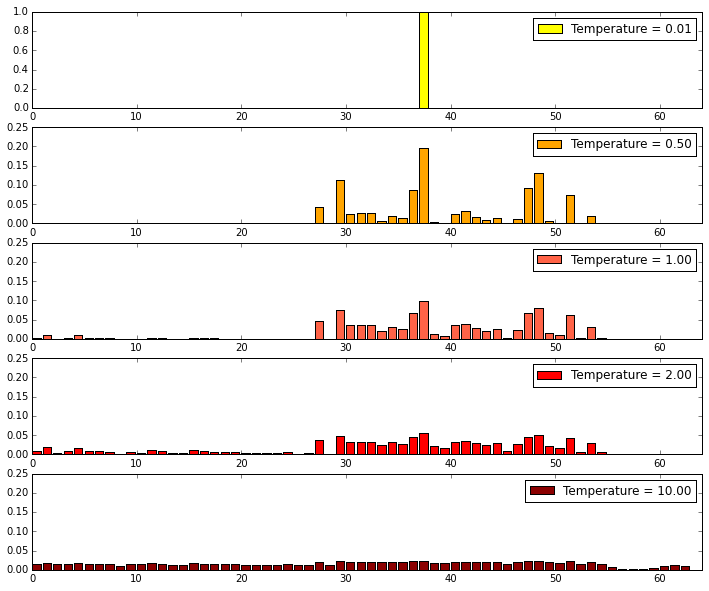

In [110]:
first_character = " "
i = np.where(np.array(ACCEPTED_CHARS)==first_character)[0]
# Build a sequence with only the first character defined
sequence = np.zeros((1, T-1, D-1), "float32")
sequence[0,0,i] = 1
out = model.predict(sequence)
# Get a distribution
distribution = out[0,0]

temperatures = [0.01, 0.5, 1., 2., 10.]
colors = ["yellow", "orange", "tomato", "red", "darkred"]
# Update temperature
plt.figure(figsize=(12,10))
for i, tmp, c in zip(range(len(temperatures)), temperatures, colors):
    plt.subplot(len(temperatures),1,i+1)
    new_distribution = update_temperature(distribution, tmp)
    plt.bar(range(new_distribution.shape[0]), new_distribution, color=c, 
            label="Temperature = %.2f"%tmp)
    plt.ylim([0,max(0.25,new_distribution.max())])
    plt.xlim([0,64])
    plt.legend()
plt.show()

### Generate a tweet - character by character

#### Temperature = 0.01 - Most probable tweet starting from a given letter

In [101]:
for first_character in "abcdefghijklmnopqrstuvwxyz":
    temperature = 0.01
    i = np.where(np.array(ACCEPTED_CHARS)==first_character)[0]

    sequence = np.zeros((1, T-1, D-1), "float32")
    sequence[0,0,i] = 1

    print "First char =", first_character, "| Tweet :", 
    for t in range(T-2):
        out = model.predict(sequence)   
        out = out.astype("float64")
        next_char = sample(out[0, t], temperature=temperature)
        sequence[0,t+1,next_char] = 1
        if next_char != 62:
            char = ACCEPTED_CHARS[next_char]
        else:
            break
        #print char,

    print onehot2tweet(sequence, ACCEPTED_CHARS)[0] + "\n"

 First char = a | Tweet : a sex pics https://t.co/tmktakntqn

First char = b | Tweet : beautiful sex https://t.co/ncetaxnaac

First char = c | Tweet : come join me, or you'll be left behind #bigolive. https://t.co/qqhdqxqtee https://t.co/ttxhhhhhhq

First char = d | Tweet : don't start the star that i want to be a start of the state of the state of the state of the state of the state of the state of the state of the state of the st

First char = e | Tweet : every mom on christmas while you opening up that gift they swore they wasn't getting you https://t.co/qhghhhhhhh

First char = f | Tweet : for the state of the state of the state of the state of the state of the state of the state of the state of the state of the state of the state of the state of 

First char = g | Tweet : good to the start of the state of the state of the state of the state of the state of the state of the state of the state of the state of the state of the state

First char = h | Tweet : how to start the star the

### Temperature = 1. 

In [111]:
first_character = "t"
temperature = 1.
i = np.where(np.array(ACCEPTED_CHARS)==first_character)[0]

sequence = np.zeros((1, T-1, D-1), "float32")
sequence[0,0,i] = 1

print first_character,
for t in range(T-2):
    out = model.predict(sequence)   
    out = out.astype("float64")
    next_char = sample(out[0, t], temperature=temperature)
    sequence[0,t+1,next_char] = 1
    if next_char != 62:
        char = ACCEPTED_CHARS[next_char]
    else:
        break
    print char,
    
onehot2tweet(sequence, ACCEPTED_CHARS)

t o m n v a n   p a n k n e t s   t o   l i k e   a   w o n d e r i n g   r a t u h e d   & a m p ;   y e s r ' t   d e v i n i a t   i n   u n t i d e .   i ' v e   a l w a y s   f r i e n d   a b o u t   t h e   s l a w e r   m u c h   w i l l   b e s t   k a d m i n   u   m a n   s o m e   5 1   l � � �

["tomnvan panknets to like a wondering ratuhed &amp; yesr't deviniat in untide. i've always friend about the slawer much will best kadmin u man some 51 l\xe2\x80\xa6"]

### Lower  temperature

In [144]:
first_character = " "
temperature = 0.5
i = np.where(np.array(ACCEPTED_CHARS)==first_character)[0]

sequence = np.zeros((1, T-1, D-1), "float32")
sequence[0,0,i] = 1

print first_character,
for t in range(T-2):
    out = model.predict(sequence)   
    out = out.astype("float64")
    next_char = sample(out[0, t], temperature=temperature)
    sequence[0,t+1,next_char] = 1
    if next_char != 62:
        char = ACCEPTED_CHARS[next_char]
    else:
        break
    print char,
    
onehot2tweet(sequence, ACCEPTED_CHARS)

  h o l d   a n d   a   h a p p y   l i f e   o n   t h e   b l a c k   c h i c k i n g   a n d   s e e   t h e m   a n d   l o v e   t h e   d i m f a n t h e r s   a n d   i   c a n ' t   b e   t h e   m a n   i n   t h e   h i g h e r   a n d   h a r d   t h e y   c o u l d   b e   c h r i s t m a s   i f   t h e y

[" hold and a happy life on the black chicking and see them and love the dimfanthers and i can't be the man in the higher and hard they could be christmas if they"]